In [263]:
import numpy as np
np.random.seed(2)
import matplotlib.pyplot as plt
import copy

In [327]:
a=np.array([-1,2,3])

a[a<0]=a[a<0]*2

a

array([-2,  2,  3])

In [328]:
def f(x,is_derivative=False,name='elu'):
    if name=='relu':
        return relu(x,is_derivative)
    if name=='sigmoid':
        return sigmoid(x,is_derivative)
    if name=='tanh':
        return tanh(x,is_derivative)
    if name=='elu':
        return elu(x,is_derivative)
    
def sigmoid(a,is_derivative=False):
    x=copy.copy(a)
    if is_derivative:
        return x*(1-x)
    return 1/(1+np.exp(-x))    

def relu(a,is_derivative=False):
    x=copy.copy(a)
    if not is_derivative:
        return np.maximum(x,0)
    else:
        x[x>=0]=1
        x[x<0]=0
        return x
def tanh(a,is_derivative=False):
    x=copy.copy(a)
    if not is_derivative:
        return np.tanh(x)
    else:
        return 1-x**2
    
def elu(a,is_derivative=False):
    alpha=1
    x=copy.copy(a)
    if not is_derivative:
        x[x<0]=alpha*(np.exp(x[x<0])-1)
        return x
    else:
        x[x>=0]=1
        x[x<0]=x[x<0]+alpha
        return x

In [281]:

def mse(x,y):
    return 0.5*np.mean(x-y)**2
        

def neural_network(x,y,hidden=[2]):
    error_list=[]
    w1=2*np.random.rand(x.shape[1],hidden[0])-1
    w2=2*np.random.rand(hidden[0],y.shape[1])-1
    bias=2*np.random.rand(len(hidden)+1)-1
    gamma = 0.01
    for iter in range(100000):
        out1 = f(x.dot(w1)+bias[0])
        out2 = f(out1.dot(w2)+bias[1])
        error = mse(out2,y)
        
        delta2 = (out2-y)*f(out2,True)
        
        error1 = delta2.dot(w2.T)
        delta1 = error1 * f(out1,True)
        
        
        w2 -= gamma* out1.T.dot(delta2)
        bias[1] -= gamma * np.mean(delta2)
        bias[0] -= gamma * np.mean(delta1)
        w1 -= gamma* x.T.dot(delta1)

        error_list.append(error)
    plt.clf()
    plt.plot(error_list)
    plt.show()
    print out2
    return w1,w2

# def neural_network(x,y,hidden=[2]):
#     error_list=[]
#     w1=2*np.random.rand(x.shape[1],1)-1
#     for iter in range(100):
#         out=f(x.dot(w1))
#         error=mse(out,y)
#         w1 -= 1 * x.T.dot(((out-y)*out*(1-out)))
#         error_list.append(error)
#     plt.clf()
#     plt.plot(error_list)
#     plt.show()
#     print out
#     return w1
                                        
x=np.array([[0,0],[0,1],[1,0],[1,1]])
y=np.array([[0,1,1,0]]).T

# w1,w2=neural_network(x,y,[2])


[[  1.21603748e-05]
 [  1.00107879e+00]
 [  9.98927657e-01]
 [  1.10959995e-04]]


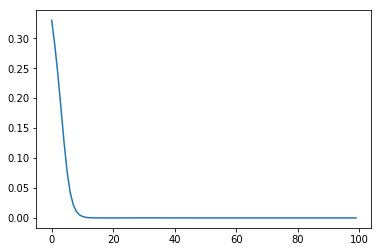

In [330]:
def show_error(error_list):
    plt.clf()
    plt.plot(error_list)
    plt.show()


def neural_network(x,y,epochs,hidden=[2,3],bias=True,gamma=0.1):
    length=len(hidden)
    error_list=[]
    
#     initialize the weigths for consistant matrix multiplications
    weights_list=[2*np.random.rand(x.shape[1],hidden[0])-1]
    for i in range(1,length):
        weights_list.append(2*np.random.rand(hidden[i-1],hidden[i])-1)
    weights_list.append(2*np.random.rand(hidden[-1],y.shape[1])-1)
    
#     add bias 
#     there are as many bias as hidden_layer+1
    if bias:
        bias=2*np.random.rand(length+1)-1
    else:
        bias=np.zeros(length+1)
        
#     learning rate
    for iter in range(epochs):
#         list containing the output of each layer
#         len(out_list)=len(hidden)+1
        out_list=[]
        for j in range(0,length+1):
#             if first layer the first element is x
            if j==0:
                out_list.append(f(x.dot(weights_list[0])+bias[j]))
#             else this is the result of the previous layer
            else:
                out_list.append(f(out_list[-1].dot(weights_list[j])+bias[j]))
#         print out_list
#         compute the error of the algorithm (for the error curve)        
        error = mse(out_list[-1],y)
        
#         compute the first two partial derivative a the thumb rule
        delta_list=[(out_list[-1]-y)*f(out_list[-1],True)]
#         print out_list
        for j in range(length,-1,-1):
#             print out_list
#             we use the previous result the previous delta
#             we then multiply it by the weights of the next layer
            delta_list.append(delta_list[-1].dot(weights_list[j].T)*f(out_list[j-1],True))
        
#         update the weights between each layer 
#         there are (lengths+1) weights matrix
        for j in range(0,length+1):
#             if this is the first weights matrix, then the input isn t the result of the previous layer but x (input data)
            if j==0:
                weights_list[j] -= gamma* x.T.dot(delta_list[length])
#             if this is not the first weights matrix, then the input is the result of the previous layer
            else:
                weights_list[j] -= gamma* out_list[j-1].T.dot(delta_list[length-j])
        
        for j in range(length,-1,-1):
            bias[j] -= gamma * np.mean(delta_list[j+1])
#         we append each error to a list to see the evolution of the error
        error_list.append(error)
    print out_list[-1]
#     show the error with pyplot
    show_error(error_list)

x=np.array([[0,0],[0,1],[1,0],[1,1]])
y=np.array([[0,1,1,0]]).T

neural_network(x,y,hidden=[4,2],epochs=100,gamma=0.1,bias=True)